## **Method of Importance Reweighting**

#### First Try: Data too complex

Weighted Logistic Regression - Mean accuracy: 0.5005, Standard deviation: 0.0373
Unweighted Logistic Regression - Mean accuracy: 0.5000, Standard deviation: 0.0372
SVM - Mean accuracy: 0.4973, Standard deviation: 0.0399


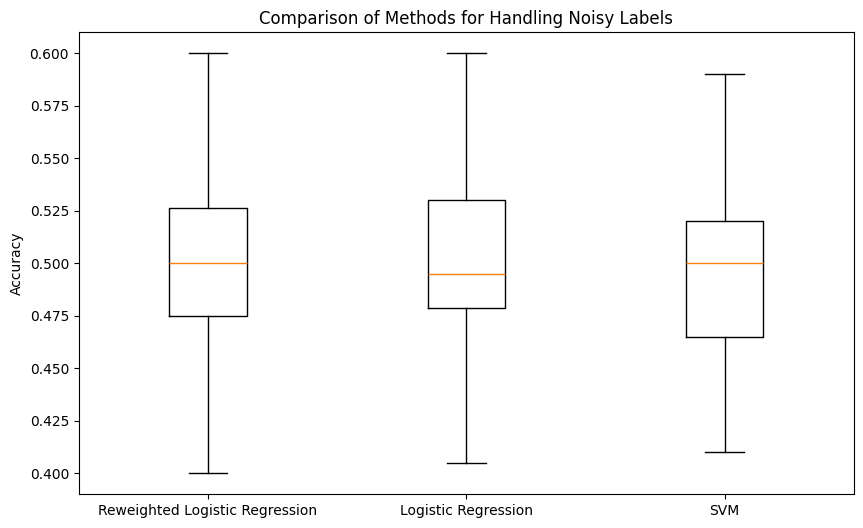

In [21]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate=0.2, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate = noise_rate
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self):
        """
        Generate a synthetic dataset with noisy labels.
        """
        if self.seed is not None:
            np.random.seed(self.seed)
        self.X = np.random.randn(self.n_samples, self.n_features)
        self.y = np.random.randint(0, 2, size=self.n_samples)
        self.y_noisy = self.y.copy()
        n_noisy = int(self.noise_rate * self.y.shape[0])
        noise_indices = np.random.choice(self.y.shape[0], n_noisy, replace=False)
        self.y_noisy[noise_indices] = 1 - self.y_noisy[noise_indices]
    
    def get_data(self):
        """
        Return the generated data.
        """
        if self.X is None or self.y is None or self.y_noisy is None:
            self.generate_data()
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            self.seed = self.seed + i if self.seed is not None else None
            self.generate_data()
            datasets.append((self.X.copy(), self.y.copy(), self.y_noisy.copy()))
        return datasets

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate=0.2, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for X, y, y_noisy in datasets:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)
        
        rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
        weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)
        
        # Logistic Regression with Reweighting
        clf_weighted_lr = train_classifier(X_train, y_train_noisy, weights)
        accuracy_weighted_lr = evaluate_classifier(clf_weighted_lr, X_test, y_test)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Reweighting
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        accuracy_unweighted_lr = evaluate_classifier(clf_unweighted_lr, X_test, y_test)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        accuracy_svm = evaluate_classifier(clf_svm, X_test, y_test)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Set a seed for reproducibility
seed = 42

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=seed)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)
mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)
mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Boxplot visualization function
def visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    data = [accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=['Reweighted Logistic Regression', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies using boxplot
visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

#### Second try: Using the same data simulation as in the other methods.

Weighted Logistic Regression - Mean accuracy: 0.5024, Standard deviation: 0.0340
Unweighted Logistic Regression - Mean accuracy: 0.8187, Standard deviation: 0.0795
SVM - Mean accuracy: 0.9143, Standard deviation: 0.0417


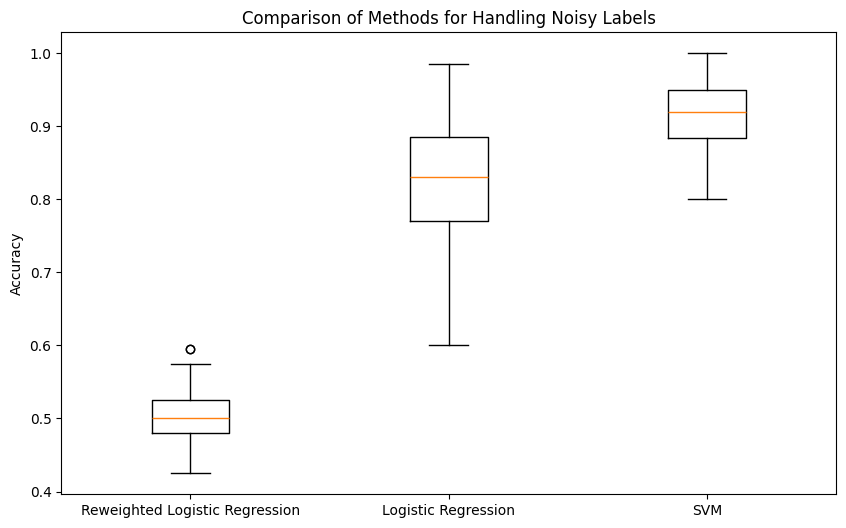

In [22]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate=0.2, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate = noise_rate
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """

        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)

        self.y_noisy = self.y.copy()
        n_noisy = int(self.noise_rate * self.y.shape[0])
        
        # Introduce noise while ensuring no class is fully eliminated
        class_1_indices = np.where(self.y_noisy == 1)[0]
        class_minus_1_indices = np.where(self.y_noisy == -1)[0]
        
        # Apply noise separately to each class, ensuring that we don't end up with an empty class
        if len(class_1_indices) > 1:
            noise_class_1 = np.random.choice(class_1_indices, size=min(len(class_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_1] = -1
        
        if len(class_minus_1_indices) > 1:
            noise_class_minus_1 = np.random.choice(class_minus_1_indices, size=min(len(class_minus_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_minus_1] = 1
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    if p_y0_given_x.size > 0:
        rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    else:
        rho_plus_1 = 0 
    if p_y1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate=0.2, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for X, y, y_noisy in datasets:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
        weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)
        
        # Logistic Regression with Reweighting
        clf_weighted_lr = train_classifier(X_train, y_train_noisy, weights)
        accuracy_weighted_lr = evaluate_classifier(clf_weighted_lr, X_test, y_test)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Reweighting
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        accuracy_unweighted_lr = evaluate_classifier(clf_unweighted_lr, X_test, y_test)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        accuracy_svm = evaluate_classifier(clf_svm, X_test, y_test)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Set a seed for reproducibility
seed = 42

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=seed)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)

mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)

mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Boxplot visualization function
def visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    data = [accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=['Reweighted Logistic Regression', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies using boxplot
visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

Running simulation for noise_rate=0.1, n_features=10, n_samples=1000
Running simulation for noise_rate=0.1, n_features=10, n_samples=2000
Running simulation for noise_rate=0.1, n_features=10, n_samples=3000
Running simulation for noise_rate=0.1, n_features=20, n_samples=1000
Running simulation for noise_rate=0.1, n_features=20, n_samples=2000
Running simulation for noise_rate=0.1, n_features=20, n_samples=3000
Running simulation for noise_rate=0.1, n_features=30, n_samples=1000
Running simulation for noise_rate=0.1, n_features=30, n_samples=2000
Running simulation for noise_rate=0.1, n_features=30, n_samples=3000
Running simulation for noise_rate=0.2, n_features=10, n_samples=1000
Running simulation for noise_rate=0.2, n_features=10, n_samples=2000
Running simulation for noise_rate=0.2, n_features=10, n_samples=3000
Running simulation for noise_rate=0.2, n_features=20, n_samples=1000
Running simulation for noise_rate=0.2, n_features=20, n_samples=2000
Running simulation for noise_rate=

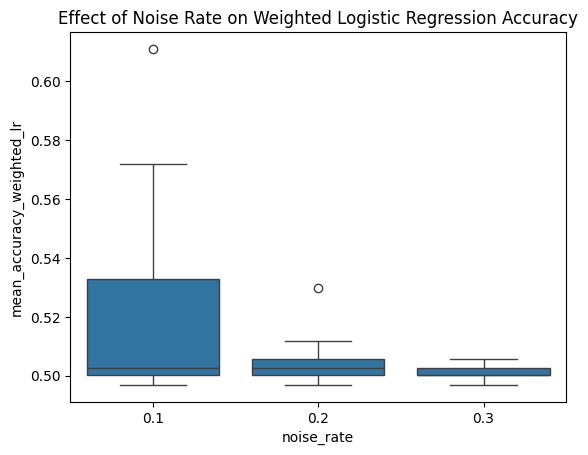

In [23]:
def simulation_study_multiple_configs(noise_rates, n_features_list, n_samples_list, n_datasets=100, test_size=0.2, seed=None):
    results = []

    for noise_rate in noise_rates:
        for n_features in n_features_list:
            for n_samples in n_samples_list:
                print(f"Running simulation for noise_rate={noise_rate}, n_features={n_features}, n_samples={n_samples}")

                accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(
                    n_datasets=n_datasets,
                    n_samples=n_samples,
                    n_features=n_features,
                    noise_rate=noise_rate,
                    test_size=test_size,
                    seed=seed
                )

                # Store the results with the corresponding parameters
                results.append({
                    'noise_rate': noise_rate,
                    'n_features': n_features,
                    'n_samples': n_samples,
                    'mean_accuracy_weighted_lr': np.mean(accuracies_weighted_lr),
                    'std_accuracy_weighted_lr': np.std(accuracies_weighted_lr),
                    'mean_accuracy_unweighted_lr': np.mean(accuracies_unweighted_lr),
                    'std_accuracy_unweighted_lr': np.std(accuracies_unweighted_lr),
                    'mean_accuracy_svm': np.mean(accuracies_svm),
                    'std_accuracy_svm': np.std(accuracies_svm)
                })
    
    return results


noise_rates = [0.1, 0.2, 0.3]
n_features_list = [10, 20, 30]
n_samples_list = [1000, 2000, 3000]

results = simulation_study_multiple_configs(noise_rates, n_features_list, n_samples_list, n_datasets=100, seed=42)

import pandas as pd
import seaborn as sns

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Example of how to visualize the effect of noise rate on accuracy
sns.boxplot(x='noise_rate', y='mean_accuracy_weighted_lr', data=df_results)
plt.title("Effect of Noise Rate on Weighted Logistic Regression Accuracy")
plt.show()

#### UCI Benchmark Dataset

Weighted Logistic Regression - Mean accuracy: 0.3772, Standard deviation: 0.0000
Unweighted Logistic Regression - Mean accuracy: 0.9180, Standard deviation: 0.0239
SVM - Mean accuracy: 0.9462, Standard deviation: 0.0162


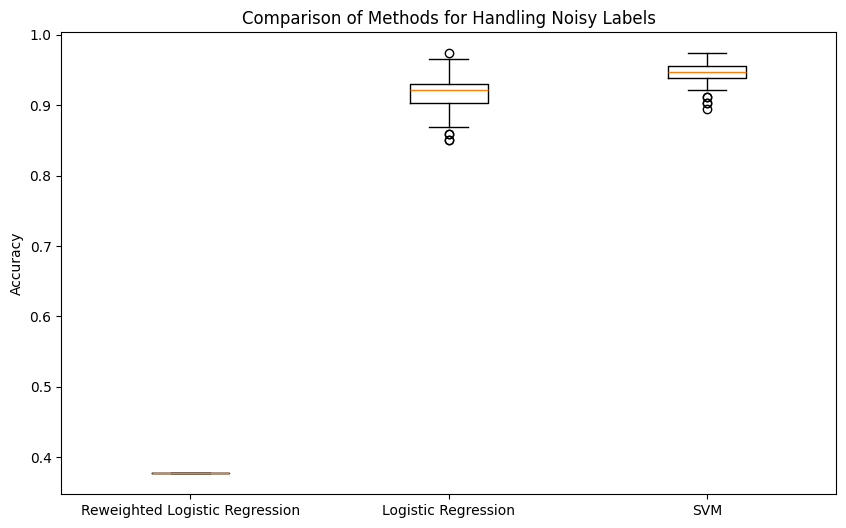

In [24]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, noise_rate=0.2, seed=None):
        self.noise_rate = noise_rate
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess the UCI dataset.
        """
        # Load dataset
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        
        # Standardize the features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert labels from {0, 1} to {-1, 1}
        self.y = np.where(self.y == 0, -1, 1)
    
    def introduce_noise(self):
        """
        Introduce noise into the labels.
        """
        self.y_noisy = self.y.copy()
        n_noisy = int(self.noise_rate * self.y.shape[0])
        
        # Introduce noise while ensuring no class is fully eliminated
        class_1_indices = np.where(self.y_noisy == 1)[0]
        class_minus_1_indices = np.where(self.y_noisy == -1)[0]
        
        # Apply noise separately to each class
        if len(class_1_indices) > 1:
            noise_class_1 = np.random.choice(class_1_indices, size=min(len(class_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_1] = -1
        
        if len(class_minus_1_indices) > 1:
            noise_class_minus_1 = np.random.choice(class_minus_1_indices, size=min(len(class_minus_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_minus_1] = 1
    
    def get_data(self):
        """
        Return the data with noisy labels.
        """
        self.load_and_preprocess_data()
        self.introduce_noise()
        return self.X, self.y, self.y_noisy

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    if p_y0_given_x.size > 0:
        rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    else:
        rho_plus_1 = 0 
    if p_y1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function
def simulation_study(n_datasets=100, noise_rate=0.2, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(noise_rate, seed)
    
    for i in range(n_datasets):
        X, y, y_noisy = simulation.get_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
        weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)
        
        # Logistic Regression with Reweighting
        clf_weighted_lr = train_classifier(X_train, y_train_noisy, weights)
        accuracy_weighted_lr = evaluate_classifier(clf_weighted_lr, X_test, y_test)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Reweighting
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        accuracy_unweighted_lr = evaluate_classifier(clf_unweighted_lr, X_test, y_test)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        accuracy_svm = evaluate_classifier(clf_svm, X_test, y_test)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Set a seed for reproducibility
seed = 42

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=seed)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)

mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)

mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Boxplot visualization function
def visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm):
    data = [accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=['Reweighted Logistic Regression', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.show()

# Visualize the accuracies using boxplot
visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)